ppda 38.81768885920885
Cumulative saliency maps have been generated and saved.
[3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


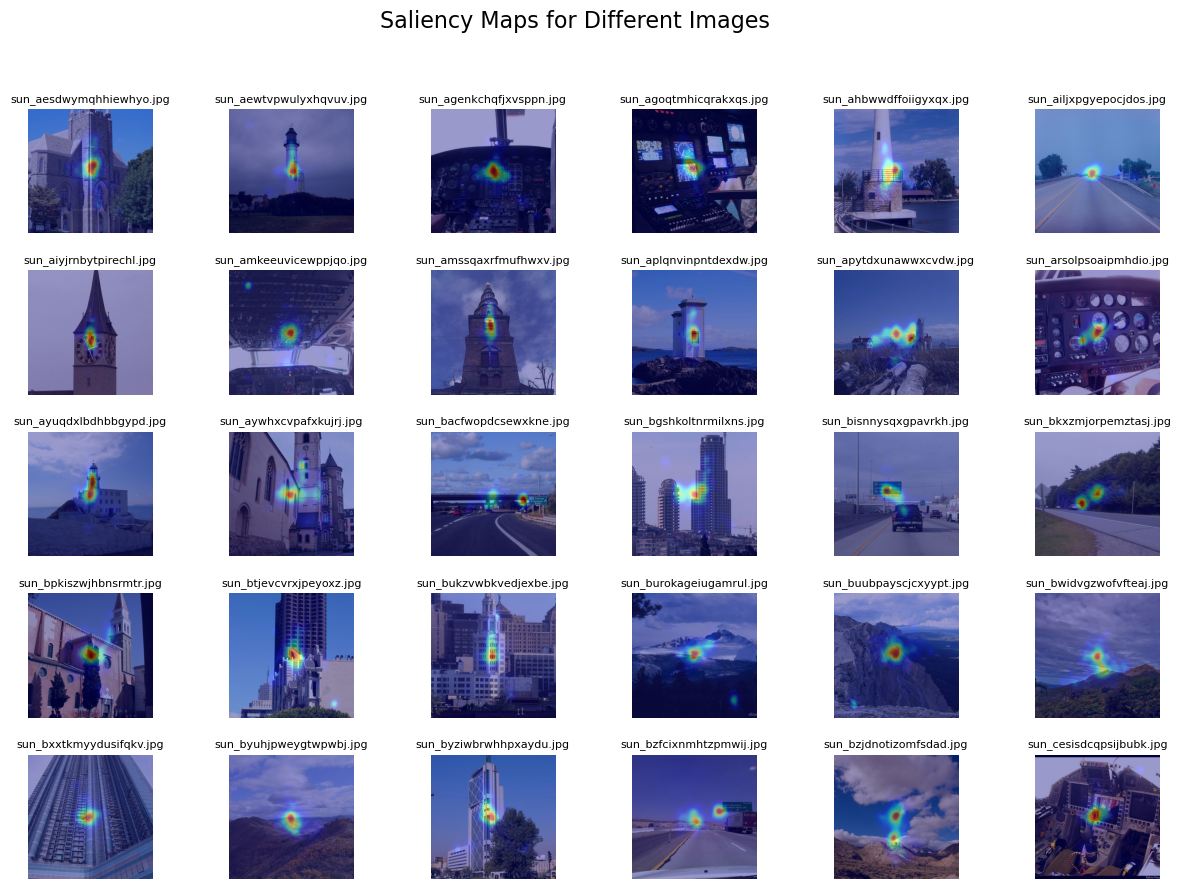

In [6]:
import pandas as pd
import cv2
import numpy as np
import os
from scipy.ndimage import gaussian_filter
import math
import re

def compute_ppda(distance, h_res, v_res, screen_w, screen_h):
    """
    Compute the number of pixels per degree of visual angle based on the experimental conditions.
    
    :param distance: int, the distance between the observer and the screen (in mm)
    :param h_res: int, the horizontal resolution of the screen
    :param v_res: int, the vertical resolution of the screen
    :param screen_w: int, the width of the screen (in mm)
    :param screen_h: int, the height of the screen (in mm)
    :return horizontal_ppda: float, the number of pixel per degree of visual angle
    """    
    pxl_density_x = h_res / screen_w
    pxl_density_y = v_res / screen_h
    
    d = 2 * distance * math.tan(np.deg2rad(0.5))
    horizontal_ppda = d * ((pxl_density_x + pxl_density_y) / 2)
    
    return horizontal_ppda

# Constants
distance = 610
h_res = 1920
v_res = 1080
screen_w = 527
screen_h = 296

ppda = compute_ppda(distance, h_res, v_res, screen_w, screen_h)
print("ppda", ppda)

def create_saliency_map(image_path, fixation_map, output_path, ppda):
    # check if image exists
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image at {image_path} not found.")
        return
    

    
    # Apply Gaussian blur to the saliency map
    sigma = ppda / np.sqrt(2)  # Calculate sigma based on PPDA
    fixation_map = gaussian_filter(fixation_map, sigma=sigma)

    #fixation_map = cv2.GaussianBlur(fixation_map, (91, 91), 0)
    
    max_count = np.max(fixation_map)
    fixation_map_normalized = (fixation_map / max_count) * 255
    fixation_map_normalized = fixation_map_normalized.astype(np.uint8)

    saliency_map = fixation_map_normalized

    heatmap = cv2.applyColorMap(saliency_map, cv2.COLORMAP_JET)

    # Resize the image to 700x700 if necessary
    if image.shape[:2] != (700, 700):
        image = cv2.resize(image, (700, 700))

    # Ensure the heatmap and image have the same size
    if heatmap.shape[:2] != image.shape[:2]:
        print(f"Size mismatch between image and heatmap for {image_path}. Resizing heatmap.")
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Blend the heatmap with the original image
    result = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
    #result = heatmap
    # Save the result
    cv2.imwrite(output_path, result)

#adds the current fixation map to the dictionary of fixation maps
def add_fixation_map(image_path, coordinates):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Image at {image_path} not found.")
        return

    coordinates = coordinates[0:120]
  
    fixation_map = np.zeros((1080, 1920), dtype=np.float32)

    # Convert coordinates to pixel coordinates and update the saliency map
    for x_norm, y_norm in coordinates:
        # Scale normalized coordinates to pixel coordinates for the 1920x1080 screen
        x = int(((x_norm + 1) / 2 ) * 1920)  # Scaling from (-1, 1) to (0, 1920) range
        y = int((y_norm + 0.5) * 1080) # Scaling from (-0.5, 0.5) to (0, 1080) range
        # Update the saliency map if coordinates are within the screen
        if 0 <= x < 1920 and 0 <= y < 1080:
            fixation_map[y, x] += 1 
    #sigma = ppda / np.sqrt(2)
    #fixation_map = gaussian_filter(fixation_map, sigma = sigma)
    fixation_map = cv2.GaussianBlur(fixation_map, (91, 91), 0)
    # Crop the saliency map to the 700x700 region
    fixation_map = fixation_map[190:890, 610:1310]
    # flip the Y coordinates
    fixation_map = np.flipud(fixation_map)

     # Update the dictionary of fixationMaps for each imagePath
    if image_path not in fixation_maps:
        fixation_maps[image_path] = fixation_map
    else:
        fixation_maps[image_path] += fixation_map

# Load the CSV files and create cumulative saliency maps
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "90experiments"))
output_dir = 'cumulative_saliency_maps_no_image2'
os.makedirs(output_dir, exist_ok=True)

fixation_maps = {}  # Dictionary to store fixation maps
allobservers = []
# Traverse through all folders
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    
    csv_file_path = os.path.join(folder_path, "eye_tracker_data.csv")
    if not os.path.isfile(csv_file_path):
        continue
    match = re.search(r'\d{1,2}$', folder)
    if match:
        observer = int(match.group())

    if(observer == 1 or observer == 2 or observer == 49 or observer == 5):
        continue
    
    #if(observer not in [70,71,73,74,76,77,79,80,82,83,85,87,88,89,86,90,18,57,6,45,48,60,63,69,3,9,12,21,15,27,30,33,36,42,24,66,51,54,72,75]):
    #    continue
    #if(observer not in [88,89,86,90,18,57,6,45,48,60,63,69,3,9,12,21,15,27,30,33,36,42,24,66,51,54,72,75]):
    #    continue
    #LEPO

    allobservers.append(observer)
    data = pd.read_csv(csv_file_path)

    filtered_data = data[data['ImagePath'].str.startswith('target')]

    grouped = filtered_data.groupby('ImagePath')

    # Generate and save fixation maps for each image in the current folder
    for image_path, group in grouped:
        # Construct full image path by going one directory back from base_dir
        full_image_path = os.path.abspath(os.path.join(base_dir, "..", image_path))

        # Extract coordinates
        coordinates = group[['PosX', 'PosY']].values

      
        output_path = os.path.join(output_dir, os.path.basename(image_path))

        # Create or update saliency map
        add_fixation_map(full_image_path, coordinates)

for imagePath, fixMap in fixation_maps.items():
    # Construct output path
    output_path = os.path.join(output_dir, os.path.basename(imagePath))
    create_saliency_map(imagePath, fixMap, output_path, ppda)

print("Cumulative saliency maps have been generated and saved.")
allobservers.sort()
print(allobservers)


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the directory containing the saliency maps
saliency_maps_dir = 'cumulative_saliency_maps'

# List all the files in the directory
saliency_map_files = [f for f in os.listdir(saliency_maps_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Sort the files to ensure they are displayed in order
saliency_map_files.sort()

# Number of images to display (ensure there are no more than 30, or adjust grid size accordingly)
num_images = min(30, len(saliency_map_files))

# Calculate grid size
cols = 6  # Number of columns
rows = (num_images + cols - 1) // cols  # Calculate the number of rows required

# Create a figure and axes for the plot
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Loop through the saliency map files and plot them
for ax, file_name in zip(axes.flatten(), saliency_map_files):
    # Load the image
    img_path = os.path.join(saliency_maps_dir, file_name)
    img = mpimg.imread(img_path)
    
    # Display the image
    ax.imshow(img)
    
    # Set the title (remove 'targetImages/' from the filename)
    title = file_name.replace('targetImages/', '')
    ax.set_title(title, fontsize=8)
    
    # Remove axis
    ax.axis('off')

# Hide any empty subplots
for i in range(num_images, len(axes.flatten())):
    axes.flatten()[i].axis('off')

# Add an overall title for the entire plot
plt.suptitle('Saliency Maps for Different Images', fontsize=16)

# Save the plot as a PNG file
plt.savefig('saliency_maps_grid.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()
